In [1]:
import os
import pydicom
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

cross correlation , elastix, fsl flirt (degrees of freedom), jacobian determinant

In [2]:
# constants
dirname = "data/9003126/T2/"

In [3]:
# functions
def get_slice(filename):
    ds = pydicom.dcmread(filename)  # plan dataset
    ds.PatientName

    shape = ds.pixel_array.shape

    # Convert to float to avoid overflow or underflow losses.
    image_2d = ds.pixel_array.astype(float)

    vmax = 2697.0 # TODO -- this should be max across all images
    
    # Rescaling grey scale between 0-255
    image_2d_scaled = (np.maximum(image_2d,0) / vmax) * 255.0

    # Convert to uint
    image_2d_scaled = np.uint8(image_2d_scaled)
    return image_2d_scaled

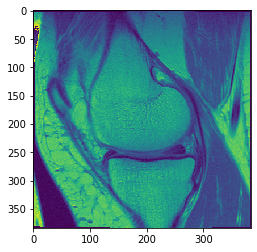

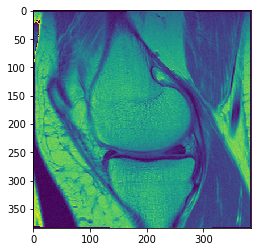

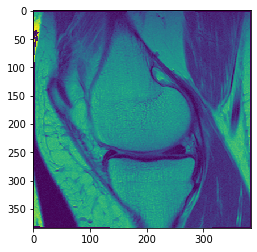

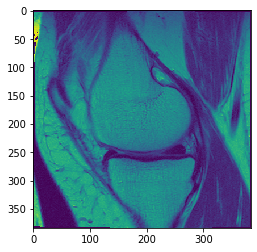

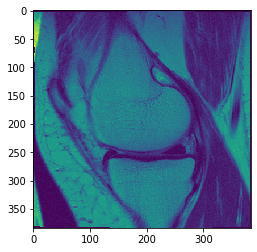

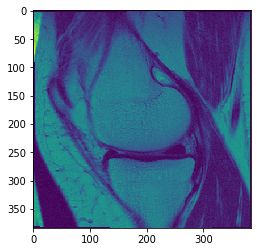

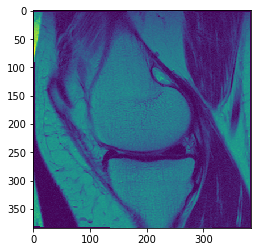

In [7]:
for i in range(7):
    img = get_slice(dirname + '%03d' % (i*29+20))
    plt.imshow(img)
    plt.show()

# Tutorial - registration

In [9]:
from dipy.data import get_fnames
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import SSDMetric, CCMetric, EMMetric
import dipy.align.imwarp as imwarp
from dipy.viz import regtools

In [100]:
from dipy.align import imwarp

In [ ]:
imwarp.

In [10]:
fname_moving = get_fnames('reg_o')
fname_static = get_fnames('reg_c')

moving = np.load(fname_moving)
static = np.load(fname_static)

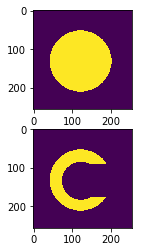

In [18]:
plt.subplot(211)
plt.imshow(moving)
plt.subplot(212)
plt.imshow(static)

In [20]:
metric = SSDMetric(static.ndim)

In [21]:
level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
mapping = sdr.optimize(static, moving)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1


/Users/dominik/anaconda3/envs/mri/lib/python2.7/site-packages/dipy/align/imwarp.py:985: RuntimeWarning: invalid value encountered in sqrt
  mean_norm = np.sqrt(sq_field).mean()


Optimizing level 0


(array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  127.        ,  127.00000763, ...,    0.        ,
          127.        ,  127.        ],
        [   0.        ,  127.00000763,  127.        , ...,    0.        ,
          127.        ,  127.        ],
        ..., 
        [   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  127.        ,  127.        , ...,    0.        ,
          127.        ,  127.        ],
        [   0.        ,  127.        ,  127.        , ...,    0.        ,
          127.        ,  127.        ]], dtype=float32),
 array([[   0.        ,    0.        ,    0.        , ...,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  126.87220764,  126.88522339, ...,    0.        ,
          127.        ,  127.        ],
        [   0.        ,  126.86068726,  127.        , ...

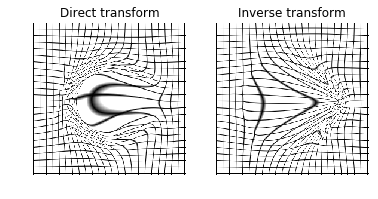

In [24]:
regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

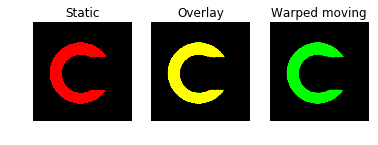

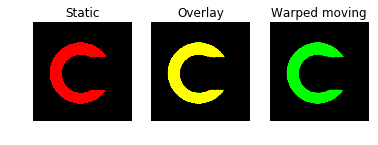

In [26]:
warped_moving = mapping.transform(moving, 'linear')
regtools.overlay_images(static, warped_moving, 'Static','Overlay','Warped moving',
   'direct_warp_result.png')

# My attempt registration

In [61]:
img1 = get_slice(dirname + '%03d' % (1*29+1))
img2 = get_slice(dirname + '%03d' % (2*29+1))

In [108]:
metric = CCMetric(img1.ndim)
level_iters = [200, 100, 50, 25]

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters, inv_iter = 50)
mapping = sdr.optimize(img1, img2)

Creating scale space from the moving image. Levels: 4. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 4. Sigma factor: 0.200000.
Optimizing level 3
Optimizing level 2
Optimizing level 1
Optimizing level 0


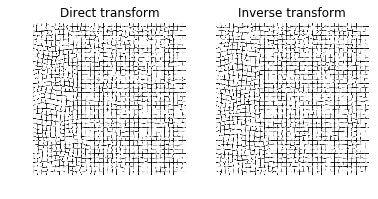

In [110]:
trans, inv_trans = regtools.plot_2d_diffeomorphic_map(mapping, 10, 'diffeomorphic_map.png')

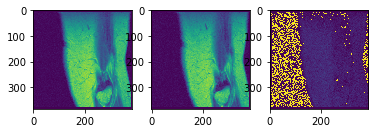

In [53]:
plt.subplot(131)
plt.imshow(img1)
plt.subplot(132)
plt.imshow(img2)
plt.subplot(133)
plt.imshow(abs(img1-img2))

In [101]:
CCMetric?

In [102]:
SSDMetric?

In [103]:
EMMetric?

In [71]:
from dipy.align import metrics 

In [81]:
metrics.SimilarityMetric?

In [89]:
SymmetricDiffeomorphicRegistration?

# My attempt fitting

In [15]:
def read_t2_weighted(slice_idx=1):
    vec_t2 = []
    for i in range(7):
        vec_t2.append(get_slice(dirname + '%03d' % (i*29 + slice_idx)))
    return np.asarray(vec_t2)

In [16]:
scan = read_t2_weighted()

We want to fit:

$$
S_{TE} = S_0 \exp{(-TE/T2)}
$$

In other form:

$$
\log S_{TE} = \log S_0 - TE \frac{1}{T2}
$$



In [53]:
te = np.array([10., 15., 20., 25., 30., 35., 40.])
t2 = 40.
s0 = 100.

measurements = s0 * np.exp(-te/t2)

In [54]:
x0 = np.ones_like(te)

In [55]:
y = np.log(measurements)
x = np.concatenate((x0[:, np.newaxis], -te[:, np.newaxis]), 1)

In [56]:
import scipy.linalg as la

In [57]:
beta, _, _, _ = la.lstsq(x, y)

In [58]:
s0_ = np.exp(beta[0])
t2_ = 1/beta[1]

s0_, t2_

(100.00000000000004, 39.99999999999994)

In [59]:
data = np.log(scan)
data[data < 0 ] = 0

/Users/dominik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [70]:
x = np.concatenate((np.ones_like(te[..., np.newaxis]), -te[..., np.newaxis]), 1)

In [71]:
x

array([[  1., -10.],
       [  1., -15.],
       [  1., -20.],
       [  1., -25.],
       [  1., -30.],
       [  1., -35.],
       [  1., -40.]])

In [72]:
matt2 = np.zeros((data.shape[1], data.shape[2]))
for ix in range(data.shape[2]):
    for iy in range(data.shape[2]):
        beta, _, _, _ = la.lstsq(x,data[:,ix,iy])
        s0_ = np.exp(beta[0])
        t2_ = 1/beta[1]
        matt2[ix, iy] = t2_

/Users/dominik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
